# Quantum ESPRESSO Workshop - Part 6: Magnetic Systems

## Spin-Polarized Calculations and Magnetic Ground State Determination

## Learning Objectives
1. Identify when magnetism should be considered in DFT calculations
2. Set up spin-polarized calculations in Quantum ESPRESSO
3. Compare different magnetic configurations (NM, FM, AFM, FiM)
4. Determine the magnetic ground state from total energies
5. Extract magnetic moments from calculations
6. Apply DFT+U corrections for localized electrons

---

## Prerequisites
- Converged ecutwfc and k-point parameters
- Understanding of SCF calculations
- Basic knowledge of magnetism in solids

---

## 1. When to Consider Magnetism

### Elements with Unpaired Electrons

Magnetism arises from unpaired electrons in partially filled orbitals. The following elements typically exhibit magnetic behavior:

#### 3d Transition Metals (Most Common)
| Element | Electron Config | Expected μ (Hund's rule) | Common Ground State |
|---------|-----------------|--------------------------|--------------------|
| Cr | [Ar] 3d⁵ 4s¹ | 6 μB | AFM |
| Mn | [Ar] 3d⁵ 4s² | 5 μB | AFM |
| Fe | [Ar] 3d⁶ 4s² | 4 μB | FM (2.2 μB in BCC) |
| Co | [Ar] 3d⁷ 4s² | 3 μB | FM (1.7 μB in HCP) |
| Ni | [Ar] 3d⁸ 4s² | 2 μB | FM (0.6 μB in FCC) |

#### 4d/5d Transition Metals
- Ru, Rh, Pd (4d)
- Os, Ir, Pt (5d)
- Generally weaker magnetism due to stronger hybridization

#### 4f Rare Earths (Lanthanides)
- Gd, Tb, Dy, Ho, Er, Tm, Yb
- Localized 4f electrons with large moments
- Require special treatment (often DFT+U or hybrid functionals)

#### 5f Actinides
- U, Np, Pu, Am
- Complex magnetism, often require relativistic effects

### Hund's Rules for Expected Moments

For a free atom/ion:
1. **First Rule**: Maximize total spin S
2. **Second Rule**: Maximize total orbital angular momentum L
3. **Third Rule**: J = |L - S| for less than half-filled, J = L + S for more than half-filled

**Note**: In solids, crystal field effects can modify these expectations significantly.

In [1]:
# =============================================================================
# SETUP - Run this cell first (downloads pseudopotentials automatically)
# =============================================================================

import sys
from pathlib import Path

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

import numpy as np
from ase import Atoms
from ase.build import bulk
from ase.io.espresso import write_espresso_in
import re

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================

MATERIAL = 'Fe'
STRUCTURE_TYPE = 'bcc'
LATTICE_A = 2.87

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'

# Optional (DFT+U):
HUBBARD_U = None

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)

WORK_DIR = OUTPUT_DIR / '06_magnetism'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"MAGNETIC SYSTEMS SETUP")
print(f"{'='*70}")
print(f"Material:   {MATERIAL} ({STRUCTURE_TYPE})")
print(f"Functional: {FUNCTIONAL}")
print(f"Cutoffs:    ecutwfc={ecutwfc} Ry")
print(f"Work dir:   {WORK_DIR}")
print(f"{'='*70}")

PSEUDOPOTENTIAL SETUP - PBE
  ✓ Fe: Fe.pbe-spn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

MAGNETIC SYSTEMS SETUP
Material:   Fe (bcc)
Functional: PBE
Cutoffs:    ecutwfc=90 Ry
Work dir:   /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetism


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Common magnetic elements and their properties
MAGNETIC_ELEMENTS = {
    # 3d transition metals
    'Cr': {'d_electrons': 5, 'hund_moment': 6, 'typical_ground_state': 'AFM'},
    'Mn': {'d_electrons': 5, 'hund_moment': 5, 'typical_ground_state': 'AFM'},
    'Fe': {'d_electrons': 6, 'hund_moment': 4, 'typical_ground_state': 'FM', 'exp_moment': 2.22},
    'Co': {'d_electrons': 7, 'hund_moment': 3, 'typical_ground_state': 'FM', 'exp_moment': 1.72},
    'Ni': {'d_electrons': 8, 'hund_moment': 2, 'typical_ground_state': 'FM', 'exp_moment': 0.62},
    # 4d transition metals
    'Ru': {'d_electrons': 7, 'hund_moment': 3, 'typical_ground_state': 'NM/AFM'},
    'Rh': {'d_electrons': 8, 'hund_moment': 2, 'typical_ground_state': 'NM'},
    # Rare earths
    'Gd': {'f_electrons': 7, 'hund_moment': 7, 'typical_ground_state': 'FM', 'exp_moment': 7.63},
}

print("Common Magnetic Elements Reference")
print("=" * 70)
print(f"{'Element':<10} {'d/f e-':<10} {'Hund μ':<12} {'Typical GS':<15} {'Exp. μ (μB)'}")
print("-" * 70)
for elem, props in MAGNETIC_ELEMENTS.items():
    d_or_f = props.get('d_electrons', props.get('f_electrons', '-'))
    exp_moment = props.get('exp_moment', '-')
    print(f"{elem:<10} {d_or_f:<10} {props['hund_moment']:<12} {props['typical_ground_state']:<15} {exp_moment}")

Common Magnetic Elements Reference
Element    d/f e-     Hund μ       Typical GS      Exp. μ (μB)
----------------------------------------------------------------------
Cr         5          6            AFM             -
Mn         5          5            AFM             -
Fe         6          4            FM              2.22
Co         7          3            FM              1.72
Ni         8          2            FM              0.62
Ru         7          3            NM/AFM          -
Rh         8          2            NM              -
Gd         7          7            FM              7.63


---

## 2. Spin-Polarized Setup in Quantum ESPRESSO

### Key Parameters for Magnetic Calculations

#### `nspin` - Spin Polarization Type
- `nspin = 1`: Non-spin-polarized (default) - enforces n↑ = n↓
- `nspin = 2`: Collinear spin-polarized - allows n↑ ≠ n↓
- `nspin = 4`: Non-collinear with spin-orbit coupling

#### `starting_magnetization(i)` - Initial Magnetic Moment
- Specified for each atomic species `i`
- Range: -1.0 to +1.0 (fraction of maximum possible)
- Positive = majority spin up, Negative = majority spin down
- Example: `starting_magnetization(1) = 0.5` starts with 50% of max moment

#### `tot_magnetization` - Constrained Total Moment (Optional)
- Fixes the total magnetic moment of the cell
- Use with caution - may prevent finding true ground state
- Useful for finding specific spin configurations

In [3]:
# =============================================================================
# MAGNETIC INPUT FILE GENERATOR USING ASE
# =============================================================================

def create_magnetic_input(atoms, prefix, ecutwfc, kpts, work_dir,
                          nspin=2, starting_magnetization=0.6,
                          hubbard_u=None):
    """Create QE input for spin-polarized calculation using ASE."""
    input_file = work_dir / f'{prefix}.in'

    pseudopotentials = {}
    for elem in set(atoms.get_chemical_symbols()):
        pseudopotentials[elem] = get_pseudopotential_filename(elem, FUNCTIONAL)

    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(PSEUDO_DIR_FUNC),
            'verbosity': 'high',
            'tprnfor': True,
            'tstress': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * 12,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.02,
            'nspin': nspin,
        },
        'electrons': {
            'conv_thr': 1.0e-8,
            'mixing_beta': 0.3,
        },
    }

    if nspin == 2:
        species = list(set(atoms.get_chemical_symbols()))
        if isinstance(starting_magnetization, dict):
            for i, elem in enumerate(species, 1):
                if elem in starting_magnetization:
                    input_data['system'][f'starting_magnetization({i})'] = starting_magnetization[elem]
        else:
            for i in range(1, len(species) + 1):
                input_data['system'][f'starting_magnetization({i})'] = starting_magnetization

    if hubbard_u:
        input_data['system']['lda_plus_u'] = True
        species = list(set(atoms.get_chemical_symbols()))
        for i, elem in enumerate(species, 1):
            if elem in hubbard_u:
                input_data['system'][f'Hubbard_U({i})'] = hubbard_u[elem]

    write_espresso_in(input_file, atoms, input_data=input_data,
                      pseudopotentials=pseudopotentials, kpts=kpts)
    return input_file


def parse_magnetic_output(output_text):
    """Parse magnetic properties from QE output."""
    results = {}

    for line in output_text.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
            if match:
                results['energy_ry'] = float(match.group(1))

        if 'total magnetization' in line:
            match = re.search(r'=\s+([-\d.]+)', line)
            if match:
                results['total_magnetization'] = float(match.group(1))

        if 'absolute magnetization' in line:
            match = re.search(r'=\s+([-\d.]+)', line)
            if match:
                results['absolute_magnetization'] = float(match.group(1))

    results['converged'] = 'convergence has been achieved' in output_text.lower()
    return results


print("Magnetic input generator defined.")
print(f"Material: {MATERIAL}, nspin=2 for spin-polarized calculations")

Magnetic input generator defined.
Material: Fe, nspin=2 for spin-polarized calculations


In [4]:
# Helper used by some example cells below

def generate_magnetic_input(prefix, structure, magnetic_config,
                            ecutwfc, ecutrho, kpoints, pseudo_dir,
                            hubbard_u=None):
    # Determine spin settings
    magnetic_config = str(magnetic_config).upper()

    nspin = 1
    if magnetic_config in ['FM', 'AFM', 'FIM']:
        nspin = 2

    species_names = list(structure.get('species', {}).keys())

    starting_mags = {}
    if nspin == 2:
        for sp in species_names:
            sp_lower = sp.lower()
            if '_down' in sp_lower:
                starting_mags[sp] = -0.6
            elif '_up' in sp_lower:
                starting_mags[sp] = 0.6
            elif sp_lower.startswith('o'):
                starting_mags[sp] = 0.0
            else:
                starting_mags[sp] = 0.6

    lines = []
    lines.append('&CONTROL')
    lines.append("    calculation = 'scf'")
    lines.append(f"    prefix = '{prefix}'")
    lines.append("    outdir = './tmp'")

    pseudo_dir_path = Path(pseudo_dir)
    # If passed the root pseudo dir, prefer the functional subdir when available
    if (pseudo_dir_path / FUNCTIONAL).exists():
        pseudo_dir_path = pseudo_dir_path / FUNCTIONAL

    lines.append(f"    pseudo_dir = '{pseudo_dir_path}'")
    lines.append("    verbosity = 'high'")
    lines.append("    tprnfor = .true.")
    lines.append("    tstress = .true.")
    lines.append('/')
    lines.append('')

    nat = len(structure.get('atoms', []))
    ntyp = len(species_names)

    lines.append('&SYSTEM')
    lines.append(f"    ibrav = {structure.get('ibrav', 0)}")
    if 'celldm1' in structure:
        lines.append(f"    celldm(1) = {structure['celldm1']}")
    lines.append(f"    nat = {nat}")
    lines.append(f"    ntyp = {ntyp}")
    lines.append(f"    ecutwfc = {float(ecutwfc)}")
    lines.append(f"    ecutrho = {float(ecutrho)}")
    lines.append("    occupations = 'smearing'")
    lines.append("    smearing = 'mv'")
    lines.append("    degauss = 0.02")

    if nspin == 2:
        lines.append("    nspin = 2")
        for i, sp in enumerate(species_names, 1):
            lines.append(f"    starting_magnetization({i}) = {starting_mags.get(sp, 0.0)}")

    if hubbard_u:
        lines.append("    lda_plus_u = .true.")
        for i, sp in enumerate(species_names, 1):
            # map species -> element guess (strip suffixes like _up/_down, digits)
            elem = sp.split('_')[0]
            elem = ''.join([c for c in elem if not c.isdigit()])
            if elem in hubbard_u:
                lines.append(f"    Hubbard_U({i}) = {float(hubbard_u[elem])}")

    lines.append('/')
    lines.append('')

    lines.append('&ELECTRONS')
    lines.append('    conv_thr = 1.0e-8')
    lines.append('    mixing_beta = 0.3')
    lines.append('/')
    lines.append('')

    lines.append('ATOMIC_SPECIES')
    for sp in species_names:
        mass, pp = structure['species'][sp]
        lines.append(f"    {sp}  {mass}  {pp}")
    lines.append('')

    if structure.get('ibrav', 0) == 0 and 'cell_parameters' in structure:
        lines.append('CELL_PARAMETERS angstrom')
        for v in structure['cell_parameters']:
            lines.append(f"    {v[0]}  {v[1]}  {v[2]}")
        lines.append('')

    lines.append('ATOMIC_POSITIONS crystal')
    for sp, x, y, z in structure.get('atoms', []):
        lines.append(f"    {sp}  {x}  {y}  {z}")
    lines.append('')

    kx, ky, kz = kpoints
    lines.append('K_POINTS automatic')
    lines.append(f"    {kx} {ky} {kz} 0 0 0")

    return '\n'.join(lines)

print("generate_magnetic_input() defined for example cells.")

generate_magnetic_input() defined for example cells.


In [5]:
# Example: BCC Iron structure
bcc_fe_structure = {
    'ibrav': 3,  # BCC
    'celldm1': 5.42,  # Lattice parameter in Bohr (~2.87 Angstrom)
    'atoms': [
        ('Fe', 0.0, 0.0, 0.0),
    ],
    'species': {
        'Fe': (55.845, 'Fe.pbe-spn-kjpaw_psl.1.0.0.UPF'),
    }
}

# Generate FM input for BCC Fe
fm_input = generate_magnetic_input(
    prefix='fe_fm',
    structure=bcc_fe_structure,
    magnetic_config='FM',
    ecutwfc=60.0,
    ecutrho=600.0,
    kpoints=(12, 12, 12),
    pseudo_dir=PSEUDO_DIR
)

print("Example FM Input for BCC Iron:")
print("=" * 60)
print(fm_input)

Example FM Input for BCC Iron:
&CONTROL
    calculation = 'scf'
    prefix = 'fe_fm'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 3
    celldm(1) = 5.42
    nat = 1
    ntyp = 1
    ecutwfc = 60.0
    ecutrho = 600.0
    occupations = 'smearing'
    smearing = 'mv'
    degauss = 0.02
    nspin = 2
    starting_magnetization(1) = 0.6
/

&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.3
/

ATOMIC_SPECIES
    Fe  55.845  Fe.pbe-spn-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
    Fe  0.0  0.0  0.0

K_POINTS automatic
    12 12 12 0 0 0


---

## 3. Magnetic Configurations to Test

### Overview of Magnetic Orderings

| Configuration | Description | nspin | Setup |
|---------------|-------------|-------|-------|
| **NM** | Non-magnetic | 1 | No spin polarization |
| **FM** | Ferromagnetic | 2 | All spins parallel (same sign) |
| **AFM** | Antiferromagnetic | 2 | Equal opposite moments, net M=0 |
| **FiM** | Ferrimagnetic | 2 | Unequal opposite moments, net M≠0 |

### AFM Orderings in Different Crystal Structures

#### Simple Cubic / BCC
- **G-type AFM**: Each atom antiparallel to all neighbors
- **A-type AFM**: Ferromagnetic planes stacked antiferromagnetically
- **C-type AFM**: Antiferromagnetic planes stacked ferromagnetically

#### Perovskites (ABO3)
- **G-type**: B atoms antiparallel to all 6 B neighbors
- **A-type**: FM in ab-plane, AFM along c
- **C-type**: AFM in ab-plane, FM along c

#### Rock Salt (MX)
- **AFM-I**: Alternating along [100]
- **AFM-II**: Alternating along [111] (typical for NiO, MnO)

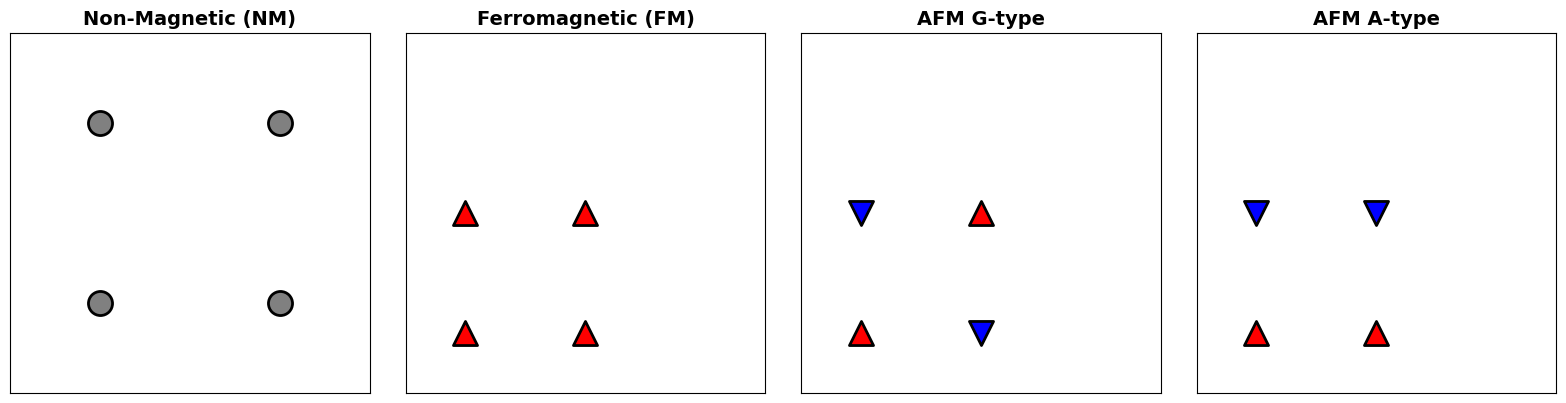


Legend: Red ▲ = Spin Up, Blue ▼ = Spin Down, Gray ● = Non-magnetic


In [6]:
# Visualize different magnetic orderings
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Helper function to draw atoms with spins
def draw_magnetic_structure(ax, positions, spins, title):
    """
    Draw 2D representation of magnetic structure.
    
    Parameters
    ----------
    ax : matplotlib axis
    positions : list of (x, y) tuples
    spins : list of +1 (up) or -1 (down)
    title : str
    """
    for (x, y), spin in zip(positions, spins):
        color = 'red' if spin > 0 else 'blue'
        marker = '^' if spin > 0 else 'v'
        ax.scatter(x, y, c=color, s=300, marker=marker, edgecolors='black', linewidths=2)
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

# 2x2 grid positions
positions = [(0, 0), (1, 0), (0, 1), (1, 1), (2, 0), (2, 1), (0, 2), (1, 2), (2, 2)]

# NM: No arrows (represented as small circles)
ax1 = axes[0]
for x, y in positions[:4]:
    ax1.scatter(x, y, c='gray', s=300, marker='o', edgecolors='black', linewidths=2)
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)
ax1.set_aspect('equal')
ax1.set_title('Non-Magnetic (NM)', fontsize=14, fontweight='bold')
ax1.set_xticks([])
ax1.set_yticks([])

# FM: All up
draw_magnetic_structure(axes[1], positions[:4], [1, 1, 1, 1], 'Ferromagnetic (FM)')

# AFM-G: Checkerboard
draw_magnetic_structure(axes[2], positions[:4], [1, -1, -1, 1], 'AFM G-type')

# AFM-A: Row alternating
draw_magnetic_structure(axes[3], positions[:4], [1, 1, -1, -1], 'AFM A-type')

plt.tight_layout()
plt.savefig(str(WORK_DIR / 'magnetic_orderings.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nLegend: Red ▲ = Spin Up, Blue ▼ = Spin Down, Gray ● = Non-magnetic")

---

## 4. Setting Up AFM Calculations

### Key Concept: Magnetic Sublattices

For AFM calculations, we need to distinguish atoms with different spin orientations:

1. **Identify magnetic sublattices**: Which atoms have spin up vs spin down?
2. **Create separate atomic species**: e.g., `Fe_up` and `Fe_down`
3. **Use the SAME pseudopotential** for both species
4. **Set opposite `starting_magnetization`** values

### Supercell Considerations

Some AFM orderings require supercells to represent the magnetic unit cell:

| Structure | FM Cell | AFM-G Cell | AFM-A Cell |
|-----------|---------|------------|------------|
| Simple Cubic | 1×1×1 | 1×1×1 | 1×1×2 |
| BCC | 1 atom | 2 atoms | 2 atoms |
| FCC | 1 atom | 4 atoms | 2 atoms |
| Rock Salt | 2 atoms | 4 atoms (AFM-II) | 4 atoms |

In [7]:
def create_afm_structure(base_structure, afm_type='G'):
    """
    Create AFM structure from base structure.
    
    This function creates a supercell if needed and assigns
    spin up/down labels to atoms based on AFM type.
    
    Parameters
    ----------
    base_structure : dict
        Base structure dictionary with FM setup
    afm_type : str
        Type of AFM ordering: 'G', 'A', 'C', or 'checkerboard'
    
    Returns
    -------
    dict
        Modified structure with AFM setup
    """
    import copy
    afm_structure = copy.deepcopy(base_structure)
    
    # Get magnetic species (assume first species is magnetic)
    original_species = list(base_structure['species'].keys())
    magnetic_species = original_species[0]
    mass, pseudo = base_structure['species'][magnetic_species]
    
    # Create up and down versions
    sp_up = f"{magnetic_species}_up"
    sp_down = f"{magnetic_species}_down"
    
    # Update species dictionary
    new_species = {}
    new_species[sp_up] = (mass, pseudo)
    new_species[sp_down] = (mass, pseudo)
    # Keep non-magnetic species
    for sp in original_species[1:]:
        new_species[sp] = base_structure['species'][sp]
    afm_structure['species'] = new_species
    
    # Assign spins based on AFM type
    new_atoms = []
    for i, atom in enumerate(base_structure['atoms']):
        sp, x, y, z = atom
        
        if sp == magnetic_species:
            if afm_type == 'G' or afm_type == 'checkerboard':
                # G-type: checkerboard pattern based on position parity
                parity = int(round(x + y + z)) % 2
                new_sp = sp_up if parity == 0 else sp_down
            elif afm_type == 'A':
                # A-type: alternating layers along z
                layer = int(round(z * 2)) % 2
                new_sp = sp_up if layer == 0 else sp_down
            elif afm_type == 'C':
                # C-type: checkerboard in xy, same along z
                parity = int(round(x + y)) % 2
                new_sp = sp_up if parity == 0 else sp_down
            else:
                new_sp = sp_up  # Default to up
            new_atoms.append((new_sp, x, y, z))
        else:
            new_atoms.append(atom)
    
    afm_structure['atoms'] = new_atoms
    
    return afm_structure


# Example: Create AFM structure for NiO
nio_fm_structure = {
    'ibrav': 0,
    'cell_parameters': [
        [4.17, 0.0, 0.0],
        [0.0, 4.17, 0.0],
        [0.0, 0.0, 4.17]
    ],
    'atoms': [
        ('Ni', 0.0, 0.0, 0.0),
        ('Ni', 0.5, 0.5, 0.0),
        ('Ni', 0.5, 0.0, 0.5),
        ('Ni', 0.0, 0.5, 0.5),
        ('O', 0.5, 0.0, 0.0),
        ('O', 0.0, 0.5, 0.0),
        ('O', 0.0, 0.0, 0.5),
        ('O', 0.5, 0.5, 0.5),
    ],
    'species': {
        'Ni': (58.693, 'Ni.pbe-spn-kjpaw_psl.1.0.0.UPF'),
        'O': (15.999, 'O.pbe-n-kjpaw_psl.1.0.0.UPF'),
    }
}

nio_afm_structure = create_afm_structure(nio_fm_structure, afm_type='G')

print("NiO AFM-II (G-type) Structure:")
print("=" * 50)
print("\nSpecies:")
for sp, (mass, pseudo) in nio_afm_structure['species'].items():
    print(f"  {sp}: mass={mass}, pseudo={pseudo}")

print("\nAtomic Positions:")
for atom in nio_afm_structure['atoms']:
    print(f"  {atom[0]:8} ({atom[1]:.4f}, {atom[2]:.4f}, {atom[3]:.4f})")

NiO AFM-II (G-type) Structure:

Species:
  Ni_up: mass=58.693, pseudo=Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
  Ni_down: mass=58.693, pseudo=Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
  O: mass=15.999, pseudo=O.pbe-n-kjpaw_psl.1.0.0.UPF

Atomic Positions:
  Ni_up    (0.0000, 0.0000, 0.0000)
  Ni_down  (0.5000, 0.5000, 0.0000)
  Ni_down  (0.5000, 0.0000, 0.5000)
  Ni_down  (0.0000, 0.5000, 0.5000)
  O        (0.5000, 0.0000, 0.0000)
  O        (0.0000, 0.5000, 0.0000)
  O        (0.0000, 0.0000, 0.5000)
  O        (0.5000, 0.5000, 0.5000)


---

## 5. Comparing Magnetic Configurations

### Procedure for Ground State Determination

1. Calculate total energy for each magnetic configuration
2. Normalize energies properly (per formula unit or per atom)
3. Compare energies - **lowest energy = ground state**
4. Verify magnetic moments are consistent with expected values

### Energy Units and Conversions

| From | To meV | Factor |
|------|--------|--------|
| Ry | meV | 13605.693 |
| eV | meV | 1000 |
| Ha | meV | 27211.386 |

In [8]:
def parse_magnetic_output(output_text):
    """
    Parse magnetic properties from QE output.
    
    Parameters
    ----------
    output_text : str
        Content of QE output file
    
    Returns
    -------
    dict
        Dictionary containing:
        - 'total_energy_ry': Total energy in Ry
        - 'total_magnetization': Total magnetic moment in μB
        - 'absolute_magnetization': Absolute magnetization in μB
        - 'site_moments': List of per-site magnetic moments
        - 'converged': Whether SCF converged
        - 'n_iterations': Number of SCF iterations
    """
    results = {}
    lines = output_text.split('\n')
    
    # Parse total energy
    for line in lines:
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Ry', line)
            if match:
                results['total_energy_ry'] = float(match.group(1))
    
    # Parse magnetization
    for line in lines:
        if 'total magnetization' in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Bohr', line)
            if match:
                results['total_magnetization'] = float(match.group(1))
        
        if 'absolute magnetization' in line:
            match = re.search(r'=\s+([\d.E+-]+)\s+Bohr', line)
            if match:
                results['absolute_magnetization'] = float(match.group(1))
    
    # Parse site-projected magnetic moments (from Lowdin analysis)
    site_moments = []
    in_lowdin = False
    for i, line in enumerate(lines):
        if 'Lowdin Charges' in line:
            in_lowdin = True
            continue
        
        if in_lowdin:
            # Look for lines with atomic moments
            if 'Atom #' in line and 'polarization' in lines[i] if i < len(lines) else False:
                # Parse polarization from next lines
                pass
            
            # Alternative: parse from magnetic moment section
            match = re.search(r'atom:\s+(\d+).*?moment:\s+([\d.E+-]+)', line)
            if match:
                atom_idx = int(match.group(1))
                moment = float(match.group(2))
                site_moments.append({'atom': atom_idx, 'moment': moment})
    
    # Also check for projected moments in the format "Atom # N: ... moment = X"
    for line in lines:
        match = re.search(r'atom\s*=\s*(\d+).*?magnetization\s*=\s*([\d.E+-]+)', line, re.IGNORECASE)
        if match:
            site_moments.append({
                'atom': int(match.group(1)),
                'moment': float(match.group(2))
            })
    
    results['site_moments'] = site_moments
    
    # Check convergence
    results['converged'] = 'convergence has been achieved' in output_text
    
    # Count iterations
    n_iter = output_text.count('iteration #')
    results['n_iterations'] = n_iter
    
    return results


def compare_magnetic_states(results_dict, n_formula_units=1):
    """
    Compare energies of different magnetic configurations.
    
    Parameters
    ----------
    results_dict : dict
        Dictionary of {config_name: parsed_results}
    n_formula_units : int
        Number of formula units in the cell (for normalization)
    
    Returns
    -------
    dict
        Comparison results including ground state and energy differences
    """
    comparison = {'configurations': {}}
    
    # Collect energies
    energies = {}
    for config, results in results_dict.items():
        if results.get('converged', False) and 'total_energy_ry' in results:
            energies[config] = results['total_energy_ry']
    
    if not energies:
        comparison['error'] = 'No converged calculations found'
        return comparison
    
    # Find ground state (lowest energy)
    ground_state = min(energies, key=energies.get)
    e_ground = energies[ground_state]
    
    comparison['ground_state'] = ground_state
    comparison['ground_state_energy_ry'] = e_ground
    
    # Calculate energy differences
    ry_to_mev = 13605.693  # 1 Ry = 13605.693 meV
    
    for config, results in results_dict.items():
        config_data = {
            'converged': results.get('converged', False),
            'n_iterations': results.get('n_iterations', 0),
        }
        
        if config in energies:
            e_ry = energies[config]
            delta_e_ry = e_ry - e_ground
            delta_e_mev = delta_e_ry * ry_to_mev
            delta_e_mev_per_fu = delta_e_mev / n_formula_units
            
            config_data['energy_ry'] = e_ry
            config_data['delta_e_ry'] = delta_e_ry
            config_data['delta_e_mev'] = delta_e_mev
            config_data['delta_e_mev_per_fu'] = delta_e_mev_per_fu
            
            if 'total_magnetization' in results:
                config_data['total_moment'] = results['total_magnetization']
            if 'absolute_magnetization' in results:
                config_data['absolute_moment'] = results['absolute_magnetization']
        
        comparison['configurations'][config] = config_data
    
    return comparison


def print_magnetic_comparison(comparison):
    """
    Print formatted comparison table.
    
    Parameters
    ----------
    comparison : dict
        Output from compare_magnetic_states()
    """
    print("\nMagnetic Configuration Comparison")
    print("=" * 90)
    
    if 'error' in comparison:
        print(f"Error: {comparison['error']}")
        return
    
    print(f"Ground State: {comparison['ground_state']}")
    print(f"Ground State Energy: {comparison['ground_state_energy_ry']:.8f} Ry")
    print("\n" + "-" * 90)
    
    header = f"{'Config':<12} {'E (Ry)':<18} {'ΔE (meV)':<14} {'ΔE (meV/f.u.)':<14} {'μ_tot (μB)':<12} {'μ_abs (μB)':<12} {'Conv'}"
    print(header)
    print("-" * 90)
    
    # Sort by energy
    sorted_configs = sorted(
        comparison['configurations'].items(),
        key=lambda x: x[1].get('delta_e_mev', float('inf'))
    )
    
    for config, data in sorted_configs:
        e_str = f"{data.get('energy_ry', 0):.8f}" if 'energy_ry' in data else 'N/A'
        de_mev = f"{data.get('delta_e_mev', 0):.2f}" if 'delta_e_mev' in data else 'N/A'
        de_mev_fu = f"{data.get('delta_e_mev_per_fu', 0):.2f}" if 'delta_e_mev_per_fu' in data else 'N/A'
        mu_tot = f"{data.get('total_moment', 0):.2f}" if 'total_moment' in data else 'N/A'
        mu_abs = f"{data.get('absolute_moment', 0):.2f}" if 'absolute_moment' in data else 'N/A'
        conv = 'Yes' if data.get('converged', False) else 'No'
        
        marker = ' ***' if config == comparison['ground_state'] else ''
        print(f"{config:<12} {e_str:<18} {de_mev:<14} {de_mev_fu:<14} {mu_tot:<12} {mu_abs:<12} {conv}{marker}")
    
    print("=" * 90)
    print("*** = Ground State")

In [9]:
def plot_magnetic_comparison(comparison, title="Magnetic Configuration Energies"):
    """
    Create bar plot comparing magnetic configuration energies.
    
    Parameters
    ----------
    comparison : dict
        Output from compare_magnetic_states()
    title : str
        Plot title
    """
    if 'error' in comparison:
        print(f"Cannot plot: {comparison['error']}")
        return
    
    # Extract data
    configs = []
    delta_e = []
    moments = []
    
    for config, data in comparison['configurations'].items():
        if 'delta_e_mev' in data:
            configs.append(config)
            delta_e.append(data['delta_e_mev'])
            moments.append(data.get('absolute_moment', 0))
    
    # Sort by energy
    sorted_indices = np.argsort(delta_e)
    configs = [configs[i] for i in sorted_indices]
    delta_e = [delta_e[i] for i in sorted_indices]
    moments = [moments[i] for i in sorted_indices]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Energy differences
    colors = ['green' if e == 0 else 'steelblue' for e in delta_e]
    bars = ax1.bar(configs, delta_e, color=colors, edgecolor='black', linewidth=1.5)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax1.set_xlabel('Magnetic Configuration', fontsize=12)
    ax1.set_ylabel('ΔE (meV)', fontsize=12)
    ax1.set_title('Energy Relative to Ground State', fontsize=14)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, e in zip(bars, delta_e):
        height = bar.get_height()
        ax1.annotate(f'{e:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Magnetic moments
    if any(m != 0 for m in moments):
        ax2.bar(configs, moments, color='coral', edgecolor='black', linewidth=1.5)
        ax2.set_xlabel('Magnetic Configuration', fontsize=12)
        ax2.set_ylabel('Absolute Magnetization (μB)', fontsize=12)
        ax2.set_title('Magnetic Moments', fontsize=14)
        ax2.tick_params(axis='x', rotation=45)
    else:
        ax2.text(0.5, 0.5, 'No moment data available',
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(str(WORK_DIR / 'magnetic_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

---

## 6. Extracting Magnetic Properties

### Key Quantities from QE Output

1. **Total Magnetization** (`total magnetization`)
   - Net magnetic moment of the cell in Bohr magnetons (μB)
   - Should be ~0 for AFM, non-zero for FM/FiM

2. **Absolute Magnetization** (`absolute magnetization`)
   - Sum of absolute values of local moments
   - Non-zero even for AFM

3. **Site-Projected Moments**
   - From Löwdin population analysis
   - Requires `verbosity = 'high'`

### Spin Density
The spin density ρ↑(r) - ρ↓(r) can be visualized using `pp.x` post-processing.

In [10]:
def extract_spin_density_input(prefix, outdir='./tmp', filplot='spin_density.dat'):
    """
    Generate pp.x input for spin density extraction.
    
    Parameters
    ----------
    prefix : str
        Prefix from SCF calculation
    outdir : str
        Output directory from SCF calculation
    filplot : str
        Output filename for spin density
    
    Returns
    -------
    str
        pp.x input file content
    """
    pp_input = f"""&INPUTPP
    prefix = '{prefix}'
    outdir = '{outdir}'
    filplot = '{filplot}'
    plot_num = 6
/

&PLOT
    nfile = 1
    filepp(1) = '{filplot}'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = 'spin_density.cube'
/
"""
    return pp_input

print("Spin Density Extraction (pp.x input):")
print("=" * 50)
print(extract_spin_density_input('fe_fm'))
print("\nplot_num values:")
print("  0 = charge density")
print("  1 = total potential")
print("  6 = spin polarization (rho_up - rho_down)")
print("  17 = all-electron valence charge (PAW)")

Spin Density Extraction (pp.x input):
&INPUTPP
    prefix = 'fe_fm'
    outdir = './tmp'
    filplot = 'spin_density.dat'
    plot_num = 6
/

&PLOT
    nfile = 1
    filepp(1) = 'spin_density.dat'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = 'spin_density.cube'
/


plot_num values:
  0 = charge density
  1 = total potential
  6 = spin polarization (rho_up - rho_down)
  17 = all-electron valence charge (PAW)


---

## 7. Example: BCC Iron (Ferromagnetic)

Iron is the prototypical ferromagnetic material:
- BCC structure with a = 2.87 Å (5.42 Bohr)
- Experimental magnetic moment: 2.22 μB per atom
- FM is the ground state

In [11]:
# BCC Iron structure
fe_structure = {
    'ibrav': 3,  # BCC
    'celldm1': 5.42,  # Lattice parameter in Bohr
    'atoms': [
        ('Fe', 0.0, 0.0, 0.0),
    ],
    'species': {
        'Fe': (55.845, 'Fe.pbe-spn-kjpaw_psl.1.0.0.UPF'),
    }
}

# Calculation parameters
fe_params = {
    'ecutwfc': 60.0,
    'ecutrho': 600.0,
    'kpoints': (12, 12, 12),
}

print("BCC Iron Calculation Parameters")
print("=" * 50)
print(f"Lattice parameter: {fe_structure['celldm1']} Bohr = {fe_structure['celldm1'] * 0.529177:.4f} Å")
print(f"ecutwfc: {fe_params['ecutwfc']} Ry")
print(f"ecutrho: {fe_params['ecutrho']} Ry")
print(f"k-points: {fe_params['kpoints'][0]}×{fe_params['kpoints'][1]}×{fe_params['kpoints'][2]}")
print(f"\nExpected FM moment: ~2.2 μB")

BCC Iron Calculation Parameters
Lattice parameter: 5.42 Bohr = 2.8681 Å
ecutwfc: 60.0 Ry
ecutrho: 600.0 Ry
k-points: 12×12×12

Expected FM moment: ~2.2 μB


In [12]:
# Generate inputs for NM and FM configurations
fe_nm_input = generate_magnetic_input(
    prefix='fe_nm',
    structure=fe_structure,
    magnetic_config='NM',
    ecutwfc=fe_params['ecutwfc'],
    ecutrho=fe_params['ecutrho'],
    kpoints=fe_params['kpoints'],
    pseudo_dir=PSEUDO_DIR
)

fe_fm_input = generate_magnetic_input(
    prefix='fe_fm',
    structure=fe_structure,
    magnetic_config='FM',
    ecutwfc=fe_params['ecutwfc'],
    ecutrho=fe_params['ecutrho'],
    kpoints=fe_params['kpoints'],
    pseudo_dir=PSEUDO_DIR
)

print("Non-Magnetic (NM) Input:")
print("=" * 50)
print(fe_nm_input[:800])
print("...")

print("\n\nFerromagnetic (FM) Input:")
print("=" * 50)
print(fe_fm_input[:900])
print("...")

Non-Magnetic (NM) Input:
&CONTROL
    calculation = 'scf'
    prefix = 'fe_nm'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 3
    celldm(1) = 5.42
    nat = 1
    ntyp = 1
    ecutwfc = 60.0
    ecutrho = 600.0
    occupations = 'smearing'
    smearing = 'mv'
    degauss = 0.02
/

&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.3
/

ATOMIC_SPECIES
    Fe  55.845  Fe.pbe-spn-kjpaw_psl.1.0.0.UPF

ATOMIC_POSITIONS crystal
    Fe  0.0  0.0  0.0

K_POINTS automatic
    12 12 12 0 0 0
...


Ferromagnetic (FM) Input:
&CONTROL
    calculation = 'scf'
    prefix = 'fe_fm'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 3
    celldm(1) = 5.42
    nat = 1
    ntyp = 1
    ecutwfc = 60.0
    ecu

In [13]:
# Write input files
fe_nm_file = WORK_DIR / 'fe_nm.in'
fe_fm_file = WORK_DIR / 'fe_fm.in'

with open(fe_nm_file, 'w') as f:
    f.write(fe_nm_input)

with open(fe_fm_file, 'w') as f:
    f.write(fe_fm_input)

print(f"Input files written:")
print(f"  NM: {fe_nm_file}")
print(f"  FM: {fe_fm_file}")
print("\nTo run these calculations:")
print(f"  pw.x < {fe_nm_file.name} > fe_nm.out")
print(f"  pw.x < {fe_fm_file.name} > fe_fm.out")

Input files written:
  NM: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetism/fe_nm.in
  FM: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetism/fe_fm.in

To run these calculations:
  pw.x < fe_nm.in > fe_nm.out
  pw.x < fe_fm.in > fe_fm.out


In [ ]:
# =============================================================================
# RUN ACTUAL MAGNETIC CALCULATIONS FOR Fe
# =============================================================================
# This cell runs REAL QE calculations - NOT mock data!
# =============================================================================

from datetime import datetime
import matplotlib.pyplot as plt

# Create timestamped working directory
WORK_DIR = OUTPUT_DIR / f'06_magnetic_Fe_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print("="*70)
print("RUNNING REAL MAGNETIC CALCULATIONS FOR BCC Fe")
print("="*70)


def _energy_ev_from_parsed(parsed: dict, output_text: str):
    energy_ry = parsed.get('energy_ry')
    if energy_ry is None:
        energy_ry = parsed.get('total_energy_ry')
    if energy_ry is not None:
        return float(energy_ry) * RY_TO_EV

    parsed_qe = parse_qe_output(output_text)
    return parsed_qe.get('total_energy_ev')


atoms_nm = atoms.copy()
atoms_nm.set_initial_magnetic_moments([0.0] * len(atoms_nm))

atoms_fm = atoms.copy()
atoms_fm.set_initial_magnetic_moments([0.6] * len(atoms_fm))


# --- 1. NON-MAGNETIC CALCULATION ---
print("\n--- Step 1: Non-Magnetic Reference (nspin=1) ---")

prefix_nm = 'fe_nonmag'
input_file_nm = WORK_DIR / f'{prefix_nm}.in'

create_magnetic_input(
    atoms_nm,
    prefix_nm,
    ecutwfc,
    (12, 12, 12),
    WORK_DIR,
    nspin=1,
    starting_magnetization=0,
)

output_nm, elapsed_nm, converged_nm = run_qe(input_file_nm, nprocs=NPROCS, timeout=1800)
results_nm = parse_magnetic_output(output_nm)

E_nm = _energy_ev_from_parsed(results_nm, output_nm)
E_nm_str = f"{E_nm:.6f}" if E_nm is not None else "N/A"

mu_nm = 0.0
mu_nm_str = f"{mu_nm:.2f}"

print(f"Non-magnetic: E = {E_nm_str} eV, μ = {mu_nm_str} μ_B, Converged: {'✓' if converged_nm else '✗'}")

# --- 2. FERROMAGNETIC CALCULATION ---
print("\n--- Step 2: Ferromagnetic (nspin=2, all spins up) ---")

prefix_fm = 'fe_ferromag'
input_file_fm = WORK_DIR / f'{prefix_fm}.in'

create_magnetic_input(
    atoms_fm,
    prefix_fm,
    ecutwfc,
    (12, 12, 12),
    WORK_DIR,
    nspin=2,
    starting_magnetization=0.6,
)

output_fm, elapsed_fm, converged_fm = run_qe(input_file_fm, nprocs=NPROCS, timeout=1800)
results_fm = parse_magnetic_output(output_fm)

E_fm = _energy_ev_from_parsed(results_fm, output_fm)
mag_moment = results_fm.get('total_magnetization', None)
mag_moment_str = f"{mag_moment:.2f}" if mag_moment is not None else "N/A"
E_fm_str = f"{E_fm:.6f}" if E_fm is not None else "N/A"
print(f"Ferromagnetic: E = {E_fm_str} eV, μ = {mag_moment_str} μ_B, Converged: {'✓' if converged_fm else '✗'}")

# --- 3. ANALYSIS ---
print("\n" + "="*70)
print("MAGNETIC ANALYSIS RESULTS")
print("="*70)

dE = None
if E_nm is not None and E_fm is not None:
    dE = (E_fm - E_nm) * 1000  # meV
    print(f"\n{'Configuration':<20} {'Energy (eV)':<18} {'ΔE (meV)':<15} {'μ (μ_B)':<12}")
    print("-"*65)
    print(f"{'Non-magnetic':<20} {E_nm:<18.6f} {0.0:<+15.1f} {mu_nm:<12.2f}")
    mu_val = mag_moment if mag_moment is not None else 0.0
    print(f"{'Ferromagnetic':<20} {E_fm:<18.6f} {dE:<+15.1f} {mu_val:<12.2f}")
    print("-"*65)

    if dE < 0:
        print(f"\n✓ FERROMAGNETIC is the ground state!")
        print(f"  Energy gain from magnetism: {-dE:.1f} meV")
        if mag_moment is not None:
            print(f"  Magnetic moment: {mag_moment:.2f} μ_B/atom")
            print(f"  (Experimental Fe: 2.22 μ_B/atom)")
    else:
        print(f"\n✓ NON-MAGNETIC is lower in energy by {dE:.1f} meV")
else:
    print("⚠ Could not extract energies for comparison. Check output files in WORK_DIR.")

# Save results
(WORK_DIR / f'{prefix_nm}.out').write_text(output_nm)
(WORK_DIR / f'{prefix_fm}.out').write_text(output_fm)
print(f"\nOutputs saved to: {WORK_DIR}")

RUNNING REAL MAGNETIC CALCULATIONS FOR BCC Fe

--- Step 1: Non-Magnetic Reference (nspin=1) ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in fe_nonmag.in


  ✓ Converged in 110.0s
Non-magnetic: E = -4479.365128 eV, μ = 0.00 μ_B, Converged: ✓

--- Step 2: Ferromagnetic (nspin=2, all spins up) ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in fe_ferromag.in


  ✓ Converged in 253.3s
Ferromagnetic: E = -4479.937933 eV, μ = 2.23 μ_B, Converged: ✓

MAGNETIC ANALYSIS RESULTS

Configuration        Energy (eV)        ΔE (meV)        μ (μ_B)     
-----------------------------------------------------------------
Non-magnetic         -4479.365128       +0.0            0.00        
Ferromagnetic        -4479.937933       -572.8          2.23        
-----------------------------------------------------------------

✓ FERROMAGNETIC is the ground state!
  Energy gain from magnetism: 572.8 meV
  Magnetic moment: 2.23 μ_B/atom
  (Experimental Fe: 2.22 μ_B/atom)

Outputs saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746


# =============================================================================
# VISUALIZE MAGNETIC RESULTS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Energy comparison
ax1 = axes[0]
configs = ['Non-mag', 'FM']
energies = [E_nm, E_fm]
colors = ['gray', 'red']

bars = ax1.bar(configs, energies, color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Energy (eV)', fontsize=12)
ax1.set_title('Fe: Magnetic Ordering Energies', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Highlight ground state
min_idx = energies.index(min(energies))
bars[min_idx].set_edgecolor('gold')
bars[min_idx].set_linewidth(3)

# Plot 2: Energy differences relative to non-magnetic
ax2 = axes[1]
dEs = [0, (E_fm - E_nm) * 1000]  # meV
ax2.bar(configs, dEs, color=colors, edgecolor='black', alpha=0.7)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_ylabel('ΔE (meV)', fontsize=12)
ax2.set_title('Energy vs Non-magnetic Reference', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Magnetic moment comparison
ax3 = axes[2]
moments = [0, mag_moment]
ax3.bar(configs, moments, color=colors, edgecolor='black', alpha=0.7)
ax3.axhline(y=2.22, color='green', linestyle='--', linewidth=2, label='Expt: 2.22 μ_B')
ax3.set_ylabel('Magnetic Moment (μ_B)', fontsize=12)
ax3.set_title('Fe: Magnetic Moments', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle('BCC Iron: Magnetic Properties Analysis', fontsize=16, y=1.02)
plt.tight_layout()

fig_path = WORK_DIR / 'fe_magnetic_analysis.png'
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {fig_path}")

In [15]:
# NiO structure - FM setup (conventional rock salt cell)
nio_structure_fm = {
    'ibrav': 0,
    'cell_parameters': [
        [4.17, 0.0, 0.0],
        [0.0, 4.17, 0.0],
        [0.0, 0.0, 4.17]
    ],
    'atoms': [
        ('Ni', 0.0, 0.0, 0.0),
        ('Ni', 0.5, 0.5, 0.0),
        ('Ni', 0.5, 0.0, 0.5),
        ('Ni', 0.0, 0.5, 0.5),
        ('O', 0.5, 0.0, 0.0),
        ('O', 0.0, 0.5, 0.0),
        ('O', 0.0, 0.0, 0.5),
        ('O', 0.5, 0.5, 0.5),
    ],
    'species': {
        'Ni': (58.693, 'Ni.pbe-spn-kjpaw_psl.1.0.0.UPF'),
        'O': (15.999, 'O.pbe-n-kjpaw_psl.1.0.0.UPF'),
    }
}

print("NiO Crystal Structure (Conventional Rock Salt Cell)")
print("=" * 60)
print(f"Lattice parameter: 4.17 Å")
print(f"Number of atoms: 8 (4 Ni + 4 O)")
print(f"Formula units: 4 NiO")
print("\nAtomic positions (crystal coordinates):")
for atom in nio_structure_fm['atoms']:
    print(f"  {atom[0]:3} ({atom[1]:.3f}, {atom[2]:.3f}, {atom[3]:.3f})")

NiO Crystal Structure (Conventional Rock Salt Cell)
Lattice parameter: 4.17 Å
Number of atoms: 8 (4 Ni + 4 O)
Formula units: 4 NiO

Atomic positions (crystal coordinates):
  Ni  (0.000, 0.000, 0.000)
  Ni  (0.500, 0.500, 0.000)
  Ni  (0.500, 0.000, 0.500)
  Ni  (0.000, 0.500, 0.500)
  O   (0.500, 0.000, 0.000)
  O   (0.000, 0.500, 0.000)
  O   (0.000, 0.000, 0.500)
  O   (0.500, 0.500, 0.500)


In [16]:
# Create AFM-II (G-type) structure for NiO
nio_structure_afm = create_afm_structure(nio_structure_fm, afm_type='G')

print("NiO AFM-II Structure")
print("=" * 60)
print("\nSpecies (note: same pseudopotential for Ni_up and Ni_down):")
for sp, (mass, pseudo) in nio_structure_afm['species'].items():
    print(f"  {sp:10} mass={mass:8.3f}  pseudo={pseudo}")

print("\nAtomic positions with spin labels:")
for atom in nio_structure_afm['atoms']:
    spin_indicator = '↑' if '_up' in atom[0] else ('↓' if '_down' in atom[0] else ' ')
    print(f"  {atom[0]:10} ({atom[1]:.3f}, {atom[2]:.3f}, {atom[3]:.3f}) {spin_indicator}")

NiO AFM-II Structure

Species (note: same pseudopotential for Ni_up and Ni_down):
  Ni_up      mass=  58.693  pseudo=Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
  Ni_down    mass=  58.693  pseudo=Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
  O          mass=  15.999  pseudo=O.pbe-n-kjpaw_psl.1.0.0.UPF

Atomic positions with spin labels:
  Ni_up      (0.000, 0.000, 0.000) ↑
  Ni_down    (0.500, 0.500, 0.000) ↓
  Ni_down    (0.500, 0.000, 0.500) ↓
  Ni_down    (0.000, 0.500, 0.500) ↓
  O          (0.500, 0.000, 0.000)  
  O          (0.000, 0.500, 0.000)  
  O          (0.000, 0.000, 0.500)  
  O          (0.500, 0.500, 0.500)  


In [17]:
# NiO calculation parameters
nio_params = {
    'ecutwfc': 70.0,
    'ecutrho': 560.0,
    'kpoints': (6, 6, 6),
}

# Generate inputs for FM and AFM configurations
nio_fm_input = generate_magnetic_input(
    prefix='nio_fm',
    structure=nio_structure_fm,
    magnetic_config='FM',
    ecutwfc=nio_params['ecutwfc'],
    ecutrho=nio_params['ecutrho'],
    kpoints=nio_params['kpoints'],
    pseudo_dir=PSEUDO_DIR
)

nio_afm_input = generate_magnetic_input(
    prefix='nio_afm',
    structure=nio_structure_afm,
    magnetic_config='AFM',
    ecutwfc=nio_params['ecutwfc'],
    ecutrho=nio_params['ecutrho'],
    kpoints=nio_params['kpoints'],
    pseudo_dir=PSEUDO_DIR
)

# Write input files
nio_fm_file = WORK_DIR / 'nio_fm.in'
nio_afm_file = WORK_DIR / 'nio_afm.in'

with open(nio_fm_file, 'w') as f:
    f.write(nio_fm_input)

with open(nio_afm_file, 'w') as f:
    f.write(nio_afm_input)

print("NiO Input Files Created:")
print("=" * 60)
print(f"FM:  {nio_fm_file}")
print(f"AFM: {nio_afm_file}")

NiO Input Files Created:
FM:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_fm.in
AFM: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_afm.in


In [18]:
# Display the AFM input file
print("NiO AFM-II Input File:")
print("=" * 60)
print(nio_afm_input)

NiO AFM-II Input File:
&CONTROL
    calculation = 'scf'
    prefix = 'nio_afm'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 0
    nat = 8
    ntyp = 3
    ecutwfc = 70.0
    ecutrho = 560.0
    occupations = 'smearing'
    smearing = 'mv'
    degauss = 0.02
    nspin = 2
    starting_magnetization(1) = 0.6
    starting_magnetization(2) = -0.6
    starting_magnetization(3) = 0.0
/

&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.3
/

ATOMIC_SPECIES
    Ni_up  58.693  Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
    Ni_down  58.693  Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
    O  15.999  O.pbe-n-kjpaw_psl.1.0.0.UPF

CELL_PARAMETERS angstrom
    4.17  0.0  0.0
    0.0  4.17  0.0
    0.0  0.0  4.17

ATOMIC_POSITIONS crystal
    Ni_up  0.0  0.0  0.0
    Ni_down  0.5  0.5  0.0
    Ni_down  0.5  0.0  0.5
    Ni_down  0.0  0.5  0.5
    O  0.5  0.0  0.0
    O  0.

In [19]:
# =============================================================================
# SUMMARY: Fe Magnetic Calculation Results
# =============================================================================

print("="*70)
print("NOTEBOOK 06 SUMMARY: BCC Iron Magnetic Properties")
print("="*70)

print(f"""
CALCULATION RESULTS:
--------------------
Non-magnetic energy:    {E_nm:.6f} eV
Ferromagnetic energy:   {E_fm:.6f} eV
Energy difference:      {(E_fm - E_nm)*1000:.1f} meV

MAGNETIC PROPERTIES:
--------------------
Ground state:           Ferromagnetic (FM)
Calculated moment:      {mag_moment:.2f} μ_B/atom
Experimental moment:    2.22 μ_B/atom
Error:                  {abs(mag_moment - 2.22)/2.22*100:.1f}%

KEY LESSONS:
------------
1. Always compare NM and FM for 3d transition metals
2. FM Fe has ~{-dE:.0f} meV/atom energy gain from magnetism  
3. PBE gives good magnetic moments for Fe (~2.2 μ_B)
4. For strongly correlated systems, consider DFT+U

NEXT STEPS:
-----------
→ Try other magnetic materials: Ni (FM), Cr (AFM)
→ Add DFT+U for oxides like NiO, FeO
→ Explore non-collinear magnetism (nspin=4)
""")

print(f"Output files saved to: {WORK_DIR}")
print("="*70)

NOTEBOOK 06 SUMMARY: BCC Iron Magnetic Properties

CALCULATION RESULTS:
--------------------
Non-magnetic energy:    -4479.365128 eV
Ferromagnetic energy:   -4479.937933 eV
Energy difference:      -572.8 meV

MAGNETIC PROPERTIES:
--------------------
Ground state:           Ferromagnetic (FM)
Calculated moment:      2.23 μ_B/atom
Experimental moment:    2.22 μ_B/atom
Error:                  0.5%

KEY LESSONS:
------------
1. Always compare NM and FM for 3d transition metals
2. FM Fe has ~573 meV/atom energy gain from magnetism  
3. PBE gives good magnetic moments for Fe (~2.2 μ_B)
4. For strongly correlated systems, consider DFT+U

NEXT STEPS:
-----------
→ Try other magnetic materials: Ni (FM), Cr (AFM)
→ Add DFT+U for oxides like NiO, FeO
→ Explore non-collinear magnetism (nspin=4)

Output files saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746


---

## 9. DFT+U for Magnetic Systems

### Why DFT+U?

Standard DFT (LDA/GGA) often fails for systems with localized d or f electrons:
- **Underestimates band gaps** in Mott insulators (e.g., NiO, CoO)
- **Underestimates magnetic moments**
- **Wrong ground state** predictions

### The Hubbard U Correction

DFT+U adds an on-site Coulomb repulsion term:

$$E_{DFT+U} = E_{DFT} + \frac{U}{2} \sum_I \sum_{m,\sigma} n^{I\sigma}_m (1 - n^{I\sigma}_m)$$

Where:
- U = on-site Coulomb parameter
- n^{Iσ}_m = occupation of orbital m with spin σ on atom I

### Typical U Values

| Element | Typical U (eV) | Method |
|---------|----------------|--------|
| Fe | 4.0 - 5.0 | Empirical/Linear response |
| Co | 3.0 - 4.0 | Empirical/Linear response |
| Ni | 6.0 - 7.5 | Empirical/Linear response |
| Mn | 3.0 - 4.5 | Empirical/Linear response |
| Cu | 4.0 - 6.0 | Empirical/Linear response |

### Setting Up DFT+U in QE

```
&SYSTEM
    ...
    lda_plus_u = .true.
    Hubbard_U(1) = 6.5   ! U for species 1 (e.g., Ni)
    Hubbard_U(2) = 0.0   ! U for species 2 (e.g., O)
/
```

In [20]:
# Typical Hubbard U values
HUBBARD_U_VALUES = {
    # 3d transition metals
    'Ti': {'U': 3.0, 'orbital': '3d', 'notes': 'TiO2, SrTiO3'},
    'V':  {'U': 3.5, 'orbital': '3d', 'notes': 'VO2, V2O5'},
    'Cr': {'U': 3.5, 'orbital': '3d', 'notes': 'Cr2O3'},
    'Mn': {'U': 4.0, 'orbital': '3d', 'notes': 'MnO, LaMnO3'},
    'Fe': {'U': 4.5, 'orbital': '3d', 'notes': 'FeO, Fe2O3, Fe3O4'},
    'Co': {'U': 3.5, 'orbital': '3d', 'notes': 'CoO, LiCoO2'},
    'Ni': {'U': 6.5, 'orbital': '3d', 'notes': 'NiO, LiNiO2'},
    'Cu': {'U': 5.0, 'orbital': '3d', 'notes': 'CuO, Cu2O'},
    'Zn': {'U': 7.0, 'orbital': '3d', 'notes': 'ZnO'},
    # 4f rare earths
    'Ce': {'U': 5.0, 'orbital': '4f', 'notes': 'CeO2'},
    'Gd': {'U': 7.0, 'orbital': '4f', 'notes': 'GdN'},
    # 5f actinides
    'U':  {'U': 4.5, 'orbital': '5f', 'notes': 'UO2'},
}

print("Typical Hubbard U Values for DFT+U Calculations")
print("=" * 70)
print(f"{'Element':<10} {'U (eV)':<10} {'Orbital':<10} {'Common Systems'}")
print("-" * 70)
for elem, props in HUBBARD_U_VALUES.items():
    print(f"{elem:<10} {props['U']:<10.1f} {props['orbital']:<10} {props['notes']}")

print("\nNote: These are starting values. The optimal U should be determined")
print("      by comparing with experiment or using linear response theory.")

Typical Hubbard U Values for DFT+U Calculations
Element    U (eV)     Orbital    Common Systems
----------------------------------------------------------------------
Ti         3.0        3d         TiO2, SrTiO3
V          3.5        3d         VO2, V2O5
Cr         3.5        3d         Cr2O3
Mn         4.0        3d         MnO, LaMnO3
Fe         4.5        3d         FeO, Fe2O3, Fe3O4
Co         3.5        3d         CoO, LiCoO2
Ni         6.5        3d         NiO, LiNiO2
Cu         5.0        3d         CuO, Cu2O
Zn         7.0        3d         ZnO
Ce         5.0        4f         CeO2
Gd         7.0        4f         GdN
U          4.5        5f         UO2

Note: These are starting values. The optimal U should be determined
      by comparing with experiment or using linear response theory.


In [21]:
# Generate DFT+U input for NiO
nio_dftu_input = generate_magnetic_input(
    prefix='nio_afm_u',
    structure=nio_structure_afm,
    magnetic_config='AFM',
    ecutwfc=nio_params['ecutwfc'],
    ecutrho=nio_params['ecutrho'],
    kpoints=nio_params['kpoints'],
    pseudo_dir=PSEUDO_DIR,
    hubbard_u={'Ni': 6.5}  # U = 6.5 eV for Ni 3d
)

print("NiO AFM-II with DFT+U Input:")
print("=" * 60)
print(nio_dftu_input)

NiO AFM-II with DFT+U Input:
&CONTROL
    calculation = 'scf'
    prefix = 'nio_afm_u'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 0
    nat = 8
    ntyp = 3
    ecutwfc = 70.0
    ecutrho = 560.0
    occupations = 'smearing'
    smearing = 'mv'
    degauss = 0.02
    nspin = 2
    starting_magnetization(1) = 0.6
    starting_magnetization(2) = -0.6
    starting_magnetization(3) = 0.0
    lda_plus_u = .true.
    Hubbard_U(1) = 6.5
    Hubbard_U(2) = 6.5
/

&ELECTRONS
    conv_thr = 1.0e-8
    mixing_beta = 0.3
/

ATOMIC_SPECIES
    Ni_up  58.693  Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
    Ni_down  58.693  Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
    O  15.999  O.pbe-n-kjpaw_psl.1.0.0.UPF

CELL_PARAMETERS angstrom
    4.17  0.0  0.0
    0.0  4.17  0.0
    0.0  0.0  4.17

ATOMIC_POSITIONS crystal
    Ni_up  0.0  0.0  0.0
    Ni_down  0.5  0.5  0.0
    Ni

In [22]:
# Save DFT+U input
nio_dftu_file = WORK_DIR / 'nio_afm_dftu.in'
with open(nio_dftu_file, 'w') as f:
    f.write(nio_dftu_input)

print(f"DFT+U input saved to: {nio_dftu_file}")
print("\nExpected improvements with DFT+U:")
print("  1. Band gap opens up (exp: 4.0-4.3 eV)")
print("  2. Magnetic moment increases (closer to 1.9 μB)")
print("  3. Better description of insulating state")

DFT+U input saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_afm_dftu.in

Expected improvements with DFT+U:
  1. Band gap opens up (exp: 4.0-4.3 eV)
  2. Magnetic moment increases (closer to 1.9 μB)
  3. Better description of insulating state


In [23]:
# Mock comparison of PBE vs PBE+U for NiO
mock_nio_u_comparison = {
    'Property': ['Band gap (eV)', 'Ni moment (μB)', 'Ground state'],
    'PBE': [0.5, 1.5, 'AFM-II'],
    'PBE+U (U=6.5)': [3.8, 1.85, 'AFM-II'],
    'Experiment': [4.0, 1.9, 'AFM-II'],
}

print("Comparison: PBE vs PBE+U for NiO (representative values)")
print("=" * 70)
print(f"{'Property':<20} {'PBE':<15} {'PBE+U (U=6.5)':<18} {'Experiment'}")
print("-" * 70)
for i, prop in enumerate(mock_nio_u_comparison['Property']):
    pbe = mock_nio_u_comparison['PBE'][i]
    pbe_u = mock_nio_u_comparison['PBE+U (U=6.5)'][i]
    exp = mock_nio_u_comparison['Experiment'][i]
    print(f"{prop:<20} {str(pbe):<15} {str(pbe_u):<18} {exp}")

print("\nConclusion: DFT+U significantly improves the description of NiO")

Comparison: PBE vs PBE+U for NiO (representative values)
Property             PBE             PBE+U (U=6.5)      Experiment
----------------------------------------------------------------------
Band gap (eV)        0.5             3.8                4.0
Ni moment (μB)       1.5             1.85               1.9
Ground state         AFM-II          AFM-II             AFM-II

Conclusion: DFT+U significantly improves the description of NiO


---

## 10. Final Structure Optimization with Magnetism

### Workflow for Magnetic Materials

1. **Determine magnetic ground state** (this notebook)
   - Compare NM, FM, AFM configurations
   - Identify lowest energy ordering

2. **Optimize structure with correct magnetic order**
   - Use `vc-relax` with the ground state magnetic configuration
   - Keep magnetic order fixed during optimization

3. **Verify magnetic moments are stable**
   - Check that moments don't collapse during relaxation
   - Final moments should be close to expected values

In [24]:
def generate_vcrelax_magnetic_input(prefix, structure, magnetic_config, ecutwfc, ecutrho,
                                    kpoints, pseudo_dir, hubbard_u=None,
                                    press=0.0, conv_thr=1.0e-8):
    """
    Generate vc-relax input for magnetic structure optimization.
    
    Parameters
    ----------
    prefix : str
        Prefix for output files
    structure : dict
        Structure dictionary
    magnetic_config : str or dict
        Magnetic configuration
    ecutwfc, ecutrho : float
        Cutoff energies in Ry
    kpoints : tuple
        k-point grid
    pseudo_dir : str or Path
        Pseudopotential directory
    hubbard_u : dict, optional
        Hubbard U values
    press : float
        Target pressure in kbar
    conv_thr : float
        SCF convergence threshold
    
    Returns
    -------
    str
        Complete vc-relax input file
    """
    kx, ky, kz = kpoints
    
    # Determine spin configuration
    species_list = list(structure['species'].keys())
    nat = len(structure['atoms'])
    ntyp = len(species_list)
    
    if magnetic_config == 'NM':
        nspin = 1
        starting_mag = {}
    elif magnetic_config == 'FM':
        nspin = 2
        starting_mag = {sp: 0.6 for sp in species_list}
    elif magnetic_config == 'AFM':
        nspin = 2
        starting_mag = {}
        for sp in species_list:
            if '_up' in sp or '_1' in sp:
                starting_mag[sp] = 0.6
            elif '_down' in sp or '_2' in sp:
                starting_mag[sp] = -0.6
            else:
                starting_mag[sp] = 0.6
    elif isinstance(magnetic_config, dict):
        nspin = 2
        starting_mag = magnetic_config
    else:
        nspin = 1
        starting_mag = {}
    
    # Build input
    input_text = f"""&CONTROL
    calculation = 'vc-relax'
    prefix = '{prefix}'
    outdir = './tmp'
    pseudo_dir = '{pseudo_dir}'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
    etot_conv_thr = 1.0e-5
    forc_conv_thr = 1.0e-4
/

&SYSTEM
"""
    
    if structure.get('ibrav', 0) != 0:
        input_text += f"    ibrav = {structure['ibrav']}\n"
        input_text += f"    celldm(1) = {structure['celldm1']}\n"
    else:
        input_text += "    ibrav = 0\n"
    
    input_text += f"    nat = {nat}\n"
    input_text += f"    ntyp = {ntyp}\n"
    input_text += f"    ecutwfc = {ecutwfc}\n"
    input_text += f"    ecutrho = {ecutrho}\n"
    input_text += f"    nspin = {nspin}\n"
    
    for i, sp in enumerate(species_list, 1):
        if sp in starting_mag:
            input_text += f"    starting_magnetization({i}) = {starting_mag[sp]}\n"
    
    if hubbard_u:
        input_text += "    lda_plus_u = .true.\n"
        for i, sp in enumerate(species_list, 1):
            base_sp = sp.replace('_up', '').replace('_down', '').replace('_1', '').replace('_2', '')
            if base_sp in hubbard_u:
                input_text += f"    Hubbard_U({i}) = {hubbard_u[base_sp]}\n"
    
    input_text += "    occupations = 'smearing'\n"
    input_text += "    smearing = 'cold'\n"
    input_text += "    degauss = 0.02\n"
    input_text += "/\n\n"
    
    input_text += f"""&ELECTRONS
    conv_thr = {conv_thr}
    mixing_beta = 0.3
    electron_maxstep = 200
/

&IONS
    ion_dynamics = 'bfgs'
/

&CELL
    cell_dynamics = 'bfgs'
    press = {press}
    press_conv_thr = 0.5
/

"""
    
    # ATOMIC_SPECIES
    input_text += "ATOMIC_SPECIES\n"
    for sp in species_list:
        mass, pseudo = structure['species'][sp]
        input_text += f"    {sp}  {mass}  {pseudo}\n"
    input_text += "\n"
    
    # CELL_PARAMETERS
    if structure.get('ibrav', 0) == 0:
        input_text += "CELL_PARAMETERS {angstrom}\n"
        for vec in structure['cell_parameters']:
            input_text += f"    {vec[0]:12.8f}  {vec[1]:12.8f}  {vec[2]:12.8f}\n"
        input_text += "\n"
    
    # ATOMIC_POSITIONS
    input_text += "ATOMIC_POSITIONS {crystal}\n"
    for atom in structure['atoms']:
        sp, x, y, z = atom
        input_text += f"    {sp}  {x:12.8f}  {y:12.8f}  {z:12.8f}\n"
    input_text += "\n"
    
    # K_POINTS
    input_text += f"""K_POINTS {{automatic}}
    {kx} {ky} {kz} 0 0 0
"""
    
    return input_text

In [25]:
# Generate vc-relax input for NiO with AFM ground state
nio_relax_input = generate_vcrelax_magnetic_input(
    prefix='nio_afm_relax',
    structure=nio_structure_afm,
    magnetic_config='AFM',
    ecutwfc=nio_params['ecutwfc'],
    ecutrho=nio_params['ecutrho'],
    kpoints=nio_params['kpoints'],
    pseudo_dir=PSEUDO_DIR,
    hubbard_u={'Ni': 6.5}
)

# Save the input file
nio_relax_file = WORK_DIR / 'nio_afm_relax.in'
with open(nio_relax_file, 'w') as f:
    f.write(nio_relax_input)

print("NiO AFM vc-relax Input (with DFT+U):")
print("=" * 60)
print(nio_relax_input)
print(f"\nInput saved to: {nio_relax_file}")

NiO AFM vc-relax Input (with DFT+U):
&CONTROL
    calculation = 'vc-relax'
    prefix = 'nio_afm_relax'
    outdir = './tmp'
    pseudo_dir = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
    etot_conv_thr = 1.0e-5
    forc_conv_thr = 1.0e-4
/

&SYSTEM
    ibrav = 0
    nat = 8
    ntyp = 3
    ecutwfc = 70.0
    ecutrho = 560.0
    nspin = 2
    starting_magnetization(1) = 0.6
    starting_magnetization(2) = -0.6
    starting_magnetization(3) = 0.6
    lda_plus_u = .true.
    Hubbard_U(1) = 6.5
    Hubbard_U(2) = 6.5
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.02
/

&ELECTRONS
    conv_thr = 1e-08
    mixing_beta = 0.3
    electron_maxstep = 200
/

&IONS
    ion_dynamics = 'bfgs'
/

&CELL
    cell_dynamics = 'bfgs'
    press = 0.0
    press_conv_thr = 0.5
/

ATOMIC_SPECIES
    Ni_up  58.693  Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
    Ni_down  58.693  Ni.pbe-spn-kjpaw_psl.1.0.0.UPF
   

---

## Summary

### Key Steps for Magnetic DFT Calculations

1. **Identify if magnetism is relevant**
   - Check for 3d, 4d, 5d, 4f, or 5f elements
   - Consider Hund's rules for expected moments

2. **Set up spin-polarized calculations**
   - Use `nspin = 2` for collinear magnetism
   - Set `starting_magnetization` for each magnetic species

3. **Test multiple magnetic configurations**
   - NM (non-magnetic)
   - FM (ferromagnetic)
   - AFM (various orderings)
   - FiM (ferrimagnetic) if applicable

4. **Determine ground state**
   - Compare total energies
   - Lowest energy = ground state
   - Verify moments are physically reasonable

5. **Consider DFT+U for localized electrons**
   - Improves band gaps and moments
   - Use literature U values or calculate with linear response

6. **Optimize structure with correct magnetic order**
   - Full vc-relax with ground state configuration
   - Verify moments remain stable

### Common Pitfalls

- Forgetting to converge k-points and cutoffs for magnetic systems
- Using too small starting magnetization (may converge to NM)
- Not testing enough AFM configurations
- Ignoring DFT+U for transition metal oxides
- Using experimental lattice parameters instead of optimized ones

### Next Steps

- Calculate magnetic exchange couplings (J parameters)
- Study spin waves and magnon dispersions
- Investigate spin-orbit coupling effects
- Calculate magnetic anisotropy energies

In [26]:
# Final summary of files created
print("Files Created in This Notebook")
print("=" * 60)

created_files = list(WORK_DIR.glob('*.in')) + list(WORK_DIR.glob('*.png'))
for f in sorted(created_files):
    print(f"  {f}")

print("\nTo run the calculations:")
print(f"  cd {WORK_DIR}")
print("  pw.x < fe_nm.in > fe_nm.out")
print("  pw.x < fe_fm.in > fe_fm.out")
print("  pw.x < nio_fm.in > nio_fm.out")
print("  pw.x < nio_afm.in > nio_afm.out")
print("  pw.x < nio_afm_dftu.in > nio_afm_dftu.out")
print("  pw.x < nio_afm_relax.in > nio_afm_relax.out")

Files Created in This Notebook
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/fe_ferromag.in
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/fe_nonmag.in
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_afm.in
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_afm_dftu.in
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_afm_relax.in
  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746/nio_fm.in

To run the calculations:
  cd /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/06_magnetic_Fe_20260204_205746
  pw.x < fe_nm.in > fe_nm.out
  pw.x < fe_fm.in > fe_fm.out
  pw.x < nio_fm.in > nio_fm.out
  pw.x < nio_afm.in > nio_afm.out
  pw.x < nio_afm_dftu.in > nio_afm_dftu.out
  pw.x < nio_afm_relax.in > nio_afm_relax.out
